In [129]:
from fastai.vision.all import *
from matplotlib import patches

In [5]:
path = untar_data("https://github.com/OlafenwaMoses/FireNET/releases/download/v1.0/fire-dataset.zip")

In [89]:
list(path.iterdir())

[Path('/home/kavindu99/.fastai/data/fire-dataset/train'),
 Path('/home/kavindu99/.fastai/data/fire-dataset/validation')]

In [6]:
path.ls()

(#2) [Path('/home/kavindu99/.fastai/data/fire-dataset/train'),Path('/home/kavindu99/.fastai/data/fire-dataset/validation')]

In [7]:
train_path = path/'train'

In [8]:
train_path.ls()

(#2) [Path('/home/kavindu99/.fastai/data/fire-dataset/train/annotations'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/images')]

In [62]:
train_annotations = train_path/'annotations'
train_imgs = train_path/'images'

In [90]:
train_imgs.ls()

(#412) [Path('/home/kavindu99/.fastai/data/fire-dataset/train/images/img (83).jpg'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/images/img (113).jpg'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/images/img (38).jpg'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/images/small (70).jpg'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/images/pic (162).jpg'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/images/pic (125).jpg'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/images/img (140).jpg'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/images/pic (43).jpg'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/images/small (94).jpg'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/images/pic (148).jpg')...]

In [63]:
train_annotations.ls()

(#412) [Path('/home/kavindu99/.fastai/data/fire-dataset/train/annotations/small (123).xml'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/annotations/img (104).xml'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/annotations/small (74).xml'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/annotations/pic (70).xml'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/annotations/img (42).xml'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/annotations/small (96).xml'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/annotations/small (75).xml'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/annotations/small (80).xml'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/annotations/small (137).xml'),Path('/home/kavindu99/.fastai/data/fire-dataset/train/annotations/pic (137).xml')...]

In [64]:
import xml.etree.ElementTree as ET

In [112]:
def get_anns(file_path):
    file = open(file_path)
    tree = ET.parse(file)
    root = tree.getroot()
    img = root[1].text
    bboxs = [int(root[6][4][1].text), int(root[6][4][0].text), int(root[6][4][3].text), int(root[6][4][2].text)]
    return img,bboxs

In [113]:
a, b = get_anns(train_annotations.ls()[0])
a, b

('small (123).jpg', [30, 91, 119, 129])

In [114]:
imgs, bboxs = [get_anns(path)[0] for path in train_annotations.ls()], [get_anns(path)[1] for path in train_annotations.ls()]

In [115]:
imgs[0], bboxs[0]

('small (123).jpg', [30, 91, 119, 129])

In [116]:
train_anns = collections.defaultdict(lambda:[])

for img, bbox in zip(imgs,bboxs):
    train_anns[img].append(bbox)
len(train_anns)

412

In [117]:
im = Image.open(train_imgs/imgs[0])

In [121]:
def bb_hw(b):
    return np.array([b[1], b[0], b[2]-b[0], b[3], b[1]])

In [118]:
def show_img(img, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [120]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), 
                        patheffects.Normal()])

In [130]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))

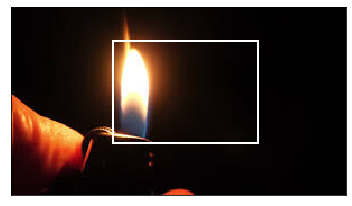

In [131]:
ax = show_img(im)
b = bb_hw(bboxs[0])
draw_rect(ax, b)

In [132]:
def draw_img(im, ann):
    ax = show_img(im, figsize=(16,8))
    b = bb_hw(ann)
    draw_rect(ax, b)

In [133]:
getters = [lambda o: train_imgs/o, lambda o: train_anns[o][0]]

In [134]:
item_tfms = [Resize(224, method='squish'),]
batch_tfms = [Rotate(), Flip(), Dihedral()]

In [135]:
ds = DataBlock(blocks=(ImageBlock, BBoxBlock),
                 splitter=RandomSplitter(),
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [ ]:
dls = ds.dataloaders(imgs, bs = 64)

In [142]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088, 4))
learn = vision_learner(dls,resnet34, custom_head=head_reg4, loss_func=nn.L1Loss(), 
                       metrics=error_rate)

In [ ]:
learn.summary()

In [ ]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))